# Sampling and MCMC


So far we have seen how to derive a posterior distribution analytically, by working out the maths, or through approximations, for example with Gaussian distributions (Laplace approximation). 

Another popular way of approximating a distribution is through sampling. In this case we do not attempt at having an parametric distribution for our posterior (either exact or approximated). Instead, we try sample our posterior parameters such as the associated histogram is close as possible to the ground-truth (and unknown) histrogram of the posterior. This kind of approach takes the name of **Markov Chain Monte Carlo (MCMC)** methods. *Monte Carlo* stands for a category of estimation methods based on sampling from random quantities. *Markov Chain* defines a stochastic evolution model, in which the probability of the current event depends only on the previous one.

In practice, in MCMC we generate samples from a multi-dimensional variable with density proportional to the one of a target function (for example of a posterior distribution $\pi(\theta)$). As you have already seen, once the density is known it is straightforward to compute all the statistical measures of interest (mean, confidence interval, ...).


A classical MCMC method is called *Metropolis-Hastings*. This method consists in two steps: a proposal and a correction. With the proposal we *perturb* the current parameter state, while with the correction we reject proposals that are "implausible", which means too far from the target distribution that we want to approximate.

The proposal distribution for a parameter $\theta'$ is defined with respect to the current parameter $\theta$ as $p(\theta'|\theta)$. A classical choice for the proposal distribution is a Gaussian centered on the current parameter: $$p(\theta'|\theta) = \mathcal{N}(\theta, \Sigma).$$

This transistion defined what we call a *random walk.*

In [1]:
# pip install pyro-ppl 


In [1]:
import scipy
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from  scipy.stats import norm
from  scipy.stats import bernoulli
from  scipy.stats import uniform
from scipy.stats import gaussian_kde

%run tools.py

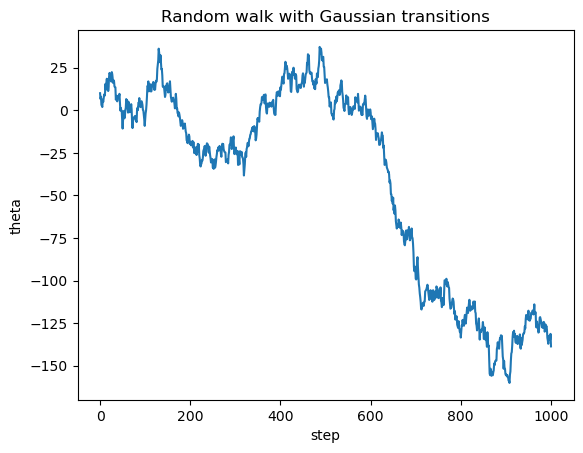

In [2]:
walk = []
current_theta = 10
sigma = 3

walk.append(current_theta)

for i in range(1000):
    new_theta = norm.rvs(current_theta, sigma, size = 1)
    
    walk.append(new_theta[0])
    current_theta = new_theta

plt.plot(walk)
plt.xlabel('step')
plt.ylabel('theta')
plt.title('Random walk with Gaussian transitions')
plt.show()


With this kind of choice we note that the proposal is symmetric with respect to $\theta$ and $\theta'$:

$$ p(\theta'|\theta) = p(\theta|\theta').$$

Concernig the correction step, Metropolis-Hastings defines the probability of accepting the proposal $a(\theta'|\theta)$ depending on the value of the target function at the parameters' values, $\pi(\theta)$ and $\pi(\theta')$:

$$ a(\theta'|\theta) = \min\left(1, \frac{p(\theta|\theta')\pi(\theta')}{p(\theta'|\theta)\pi(\theta)}\right). $$

In particular, for Gaussian proposal we simply obtain: 

$$ a(\theta|\theta') = \min\left(1, \frac{\pi(\theta')}{\pi(\theta)}\right). $$

This means that we accept our proposal $\theta'$ if it is associated to higher probability mass $\pi(\theta')$ than $\pi(\theta)$. Otherwise, we can still accept it, but with probability proportional to the ratio $\frac{\pi(\theta')}{\pi(\theta)}$. Why should we accept a sample that is worst thean the previous one? Because in this case we maximise the chance of exploring our parameter's space, and reduce the possibility of getting trapped in a local maxima. 

You can see that Metropolis-Hastings is quite simple to implement, we just need to be able to sample, and to quantifythe posterior at the proposal parameter. The combined proposal and correction procedure preferentially selects out those proposals that fall into neighborhoods of high probability mass, concentrating towards the typical set as desired. Because of its conceptual simplicity and the ease in which it can be implemented by practitioners, Metropolis-Hastings is still popular in many applications.

Let's see this method in action for estimating the posterior of the mean of a set of measurements, as we already studied during lesson 2.

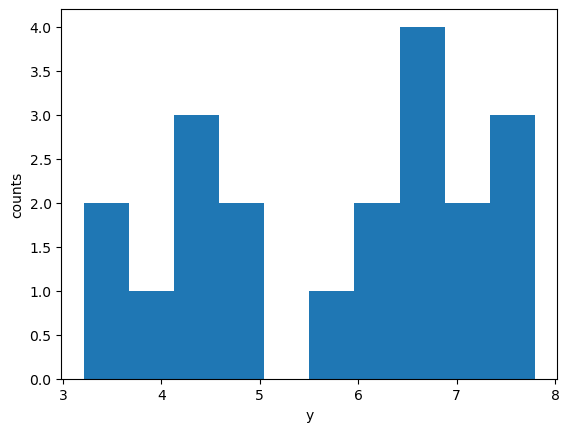

In [3]:
# Generate randomly distributed variables 

Nobs = 20
gt_mean = 5
gt_sigma = 2

y = norm.rvs(gt_mean, gt_sigma, size = Nobs)


y_mean = np.mean(y)
y_var = np.var(y)



plt.hist(y)
plt.xlabel('y')
plt.ylabel('counts')
plt.show()


In [4]:
y

array([6.95081364, 6.04478334, 3.21371461, 7.43963957, 3.70985106,
       4.62379678, 6.44421818, 6.7749267 , 3.3388514 , 5.88742677,
       4.47557617, 6.13027549, 6.54748853, 4.54874109, 7.77771735,
       4.52687797, 7.11079548, 4.73213355, 6.58398677, 7.79551238])

Similarly with what seen during lesson 2, we assume a Gaussian likelihood and a conjugate Gaussian prior for the mean $\mu$: $p(\mu)\sim\mathcal{N}(\mu_0, \sigma_0^2)$.

We now know two methods for computing the posterior $p(\mu|y)$: 

- Analytical: the mathematical derivation tells us that the posterior is:

$$p(\mu|y) = p(\theta|y)\sim N(\mu_n,\sigma_n^2),$$ with:


$$ \sigma_n^2 = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\tau_0^2}},$$

and,

$$ \mu_n = \frac{\frac{n \bar{y}}{\sigma^2} + \frac{\mu_0}{\tau_0^2}}{\frac{n}{\sigma^2} + \frac{1}{\tau_0^2}},$$


where $\bar{y} = \frac{\sum_{i=1}^{n}y_i}{n}$, is the average of the obsrevations.

- Approximated: we can approximate the posterior with the method of Laplace, which will provide us a Gaussian with mean over the max of the posterior, and related variance. In this simple case the approximation should be equal to the analytical solution up to numerical approximation.



In [8]:
mu0 = 5
sigma0 = 2


#Computing analytical posterior parameters
post_var = 1 / ( Nobs/y_var + 1/sigma0**2)
post_mean = post_var * (Nobs * y_mean/y_var + mu0/sigma0**2)

analytical_post = np.random.normal(post_mean, np.sqrt(post_var), 10000 )
analytical_density = gaussian_kde(analytical_post)

#Laplace approximation
likelihood = 'gaussian'
prior = [['gaussian', [mu0, sigma0]]]

[laplace_mean, laplace_var] = laplace_solution([10], [np.sqrt(y_var)], y, 'gaussian', prior)

laplace_post = np.random.normal(laplace_mean, np.sqrt(laplace_var.flatten()), 10000 )
laplace_density = gaussian_kde(laplace_post)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 37.19292149406843
        x: [ 5.715e+00]
      nit: 3
      jac: [ 4.768e-07]
 hess_inv: [[ 9.953e-02]]
     nfev: 8
     njev: 4


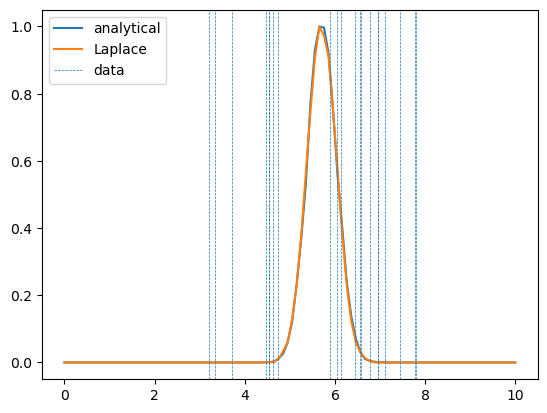

In [9]:
# Plotting posteriors
xs = np.linspace(0,10,100)
plt.plot(xs,analytical_density(xs)/np.max(analytical_density(xs)), label = 'analytical')
plt.plot(xs,laplace_density(xs)/np.max(laplace_density(xs)), label = 'Laplace')
[plt.axvline(sample, ls = '--', lw = 0.5) for sample in y]

## Simple workaround for the legend
plt.axvline(y[0], ls = '--', lw = 0.5, label= 'data')
plt.legend()

plt.show()

For applying Metropolis-Hastings we need first define our proposal Gaussian distribution:

In [10]:
def proposal(prop_mu, prop_sigma):
    return scipy.stats.norm.rvs(loc = prop_mu, scale = prop_sigma, size = 1)

And then define a routine computig our (log-)posterior:

$L(y|\theta,\sigma) \sim N(y|\theta,\sigma^2)$

$y = (y_1,y_2, \ldots, y_n)$

$N(y|\theta,\sigma^2) = \Pi_i N(y_i|\theta,\sigma^2))$

$\log(N(y|\theta,\sigma^2)) = \Sigma_i \log(N(y_i|\theta,\sigma^2))$


In [11]:
def log_likelihood(param):
    return np.sum([norm.logpdf(point,param,np.sqrt(y_var)) for point in y])

def log_prior(param):
    return norm.logpdf(param, mu0, sigma0)

def log_posterior(param):
    return log_likelihood(param) + log_prior(param)


We are finally ready to apply MH:

In [17]:
Niter = 5000
init_param = 15

# In this array we store the values of the Markov chain
param_samples = []
param_samples.append(init_param)
print(param_samples)

# In this array we store the values of the acceptance ratios
ratios = []

# In this array we store the values of the parameters that are accepted
output_samples = []

for i in range(Niter):
    # We compute the log-posterior at the current parameter
    old_log_post = log_posterior(param_samples[i])                         # pi(theta)
    print(old_log_post)
    # We compute a new proposal parameter
    new_mu = proposal(param_samples[i], 1)                                 # we can use 0.1 here and check the output
    print(new_mu)
    # We compute the log-posterior at the new parameter
    new_log_post = log_posterior(new_mu)                            # pi(theta prime)
    print(new_log_post)
    # We compute the MH-acceptance ratio    
    ratio = np.min([1, np.exp(new_log_post - old_log_post)[0]])          # alphe()


    ratios.append(ratio)
    print(ratio)
        
    # We compute a random uniforma value to compare to the acceptance ratio 
    unif_samp = uniform.rvs(0, 1, size = 1) 
    print(unif_samp)
    
    # We accept of reject based on the MH-rule
    if unif_samp < ratio:
        param_samples.append(new_mu)
        output_samples.append(new_mu)
    else:
        param_samples.append(param_samples[i])


[15]
-470.3087061194883
[14.50348152]
[-425.22701791]
1.0
[0.8420744]
[-425.22701791]
[15.06135895]
[-476.05178606]
8.454416671860486e-23
[0.25802969]
[-425.22701791]
[14.73212218]
[-445.67890426]
1.3117727754625182e-09
[0.64076384]
[-425.22701791]
[14.43945747]
[-419.59419988]
1.0
[0.43721409]
[-419.59419988]
[12.93679198]
[-299.21644674]
1.0
[0.5738662]
[-299.21644674]
[10.65012939]
[-159.56111996]
1.0
[0.4002101]
[-159.56111996]
[9.02356699]
[-92.19564197]
1.0
[0.02090294]
[-92.19564197]
[8.28692213]
[-70.43196092]
1.0
[0.37383958]
[-70.43196092]
[8.72884516]
[-82.834002]
4.110190878862784e-06
[0.42104186]
[-70.43196092]
[7.88132472]
[-60.77618646]
1.0
[0.4688947]
[-60.77618646]
[8.1630717]
[-67.30824841]
0.0014560005563586977
[0.95489936]
[-60.77618646]
[8.30631585]
[-70.93505802]
3.8730949260445785e-05
[0.62487454]
[-60.77618646]
[6.1526795]
[-38.15690538]
1.0
[0.68038437]
[-38.15690538]
[6.47291572]
[-40.08148058]
0.14593773813065974
[0.53952806]
[-38.15690538]
[4.5964196]
[-43.4

[-37.20982674]
[4.51882897]
[-44.37608411]
0.0007722074148383421
[0.16351287]
[-37.20982674]
[6.1995196]
[-38.37407772]
0.3121563854283296
[0.10537661]
[-38.37407772]
[5.61500321]
[-37.24277259]
1.0
[0.2442388]
[-37.24277259]
[5.7649987]
[-37.20567086]
1.0
[0.99281606]
[-37.20567086]
[8.39802767]
[-73.36536369]
1.977174225331899e-16
[0.86069214]
[-37.20567086]
[4.49361961]
[-44.68214361]
0.0005662512105686807
[0.01170082]
[-37.20567086]
[4.81552211]
[-41.25379264]
0.01745512844811223
[0.86187648]
[-37.20567086]
[4.90125161]
[-40.51630065]
0.03649318352658527
[0.62608973]
[-37.20567086]
[4.65965018]
[-42.78386682]
0.0037793775540520755
[0.18611444]
[-37.20567086]
[3.81318773]
[-55.35504747]
1.3116739453833499e-08
[0.57201867]
[-37.20567086]
[5.2059972]
[-38.49248442]
0.27614931629334527
[0.19982551]
[-38.49248442]
[6.84610739]
[-43.62429453]
0.005905860524309001
[0.83013974]
[-38.49248442]
[3.86390208]
[-54.39913973]
1.2354562614790615e-07
[0.75858123]
[-38.49248442]
[5.11667611]
[-38.9

[-38.63542035]
0.2390339099366472
[0.49408026]
[-37.20427049]
[6.27534326]
[-38.77235363]
0.208444359303597
[0.77597686]
[-37.20427049]
[5.65510231]
[-37.21071679]
0.9935744388830055
[0.72502636]
[-37.21071679]
[6.27102316]
[-38.74810985]
0.21494070806485593
[0.02983136]
[-38.74810985]
[5.3656719]
[-37.80460644]
1.0
[0.68041758]
[-37.80460644]
[5.76239568]
[-37.20438739]
1.0
[0.54085965]
[-37.20438739]
[6.36843616]
[-39.34033287]
0.11813284609261514
[0.35011097]
[-37.20438739]
[4.80820032]
[-41.32020115]
0.016312660446260095
[0.43180106]
[-37.20438739]
[5.57223165]
[-37.29477057]
0.9135810503682591
[0.31002766]
[-37.29477057]
[4.69313833]
[-42.43455127]
0.005858974469581199
[0.24637967]
[-37.29477057]
[6.16175002]
[-38.19723952]
0.40556710113764405
[0.95651317]
[-37.29477057]
[6.14415337]
[-38.11974569]
0.4382458984721441
[0.99408358]
[-37.29477057]
[6.22212744]
[-38.4867853]
0.30360895993891923
[0.34918106]
[-37.29477057]
[4.13877051]
[-49.66774718]
4.2314044251198985e-06
[0.05541633]

[-42.37941132]
0.006212758563376008
[0.24652447]
[-37.29826105]
[5.48507465]
[-37.45761534]
0.8526942041952698
[0.59275767]
[-37.45761534]
[6.64703483]
[-41.56031693]
0.01652796320962595
[0.67220749]
[-37.45761534]
[6.2331212]
[-38.54344854]
0.33762036399815587
[0.40888035]
[-37.45761534]
[5.7379996]
[-37.19566722]
1.0
[0.94519828]
[-37.19566722]
[5.1771203]
[-38.64423777]
0.23490583565160017
[0.91706393]
[-37.19566722]
[6.10059283]
[-37.94129238]
0.4744376079819144
[0.00687325]
[-37.94129238]
[5.90967047]
[-37.38403712]
1.0
[0.00905987]
[-37.38403712]
[5.2697946]
[-38.18691825]
0.4480362506422656
[0.30797447]
[-38.18691825]
[5.77031008]
[-37.20850092]
1.0
[0.82997992]
[-37.20850092]
[6.22730771]
[-38.51333378]
0.2712178622457283
[0.02238055]
[-38.51333378]
[7.7001114]
[-56.996354]
9.395638739347854e-09
[0.5105824]
[-38.51333378]
[5.05079885]
[-39.40656464]
0.409331123996707
[0.38423716]
[-39.40656464]
[5.74719526]
[-37.19825196]
1.0
[0.47924729]
[-37.19825196]
[5.20000769]
[-38.523271

[-57.61300506]
9.547822023686027e-09
[0.20942215]
[-39.1460523]
[6.64380547]
[-41.53011689]
0.0921751601718715
[0.39436389]
[-39.1460523]
[6.93885628]
[-44.72187799]
0.0037883462732237827
[0.67631594]
[-39.1460523]
[6.38435051]
[-39.44614429]
0.7407500731938441
[0.16082739]
[-39.44614429]
[8.04295817]
[-64.4259917]
1.4170661131497262e-11
[0.03866782]
[-39.44614429]
[7.1577307]
[-47.65465496]
0.00027232600362668254
[0.12552985]
[-39.44614429]
[6.01527544]
[-37.64701071]
1.0
[0.82038114]
[-37.64701071]
[4.52663367]
[-44.28262387]
0.0013127735547140606
[0.50225106]
[-37.64701071]
[4.99381493]
[-39.8029248]
0.11579729277270197
[0.17549701]
[-37.64701071]
[6.80725208]
[-43.19017138]
0.003914135967877252
[0.95580593]
[-37.64701071]
[5.88708272]
[-37.34233584]
1.0
[0.98348013]
[-37.34233584]
[4.32064278]
[-46.9544181]
6.691534346951884e-05
[0.9823265]
[-37.34233584]
[7.20900842]
[-48.41133284]
1.558818960623003e-05
[0.63618332]
[-37.34233584]
[6.10663998]
[-37.96492602]
0.5365528676650055
[0.

[-39.16618095]
0.2502766891364987
[0.51241145]
[-37.78099273]
[6.12890802]
[-38.05512198]
0.7602338114669938
[0.34044044]
[-38.05512198]
[6.90233209]
[-44.27933746]
0.001980877248791139
[0.83812118]
[-38.05512198]
[6.86505493]
[-43.8414937]
0.0030690975436860036
[0.74772432]
[-38.05512198]
[6.31346838]
[-38.99443546]
0.39089610309782874
[0.15328429]
[-38.99443546]
[6.84544447]
[-43.61676063]
0.009829913183615568
[0.73411369]
[-38.99443546]
[6.03634128]
[-37.71287287]
1.0
[0.6635381]
[-37.71287287]
[5.09403685]
[-39.12758509]
0.24299553349816858
[0.14463183]
[-39.12758509]
[1.55948409]
[-123.92410791]
1.4905208409878735e-37
[0.68132345]
[-39.12758509]
[5.03660689]
[-39.50222819]
0.6875346131108272
[0.09285789]
[-39.50222819]
[5.06829028]
[-39.29144441]
1.0
[0.16655221]
[-39.29144441]
[3.31411695]
[-66.14031281]
2.1861734176094305e-12
[0.88374052]
[-39.29144441]
[5.75496791]
[-37.20109926]
1.0
[0.69138567]
[-37.20109926]
[5.89766427]
[-37.36123318]
0.8520296805268237
[0.36416485]
[-37.36

[-39.89942058]
[6.77099967]
[-42.79880806]
0.0550569333290194
[0.46407192]
[-39.89942058]
[5.62096417]
[-37.23698506]
1.0
[0.67597406]
[-37.23698506]
[5.33122206]
[-37.93134504]
0.49939396891083926
[0.55401564]
[-37.23698506]
[8.2350054]
[-69.10377456]
1.446868848206051e-14
[0.24045983]
[-37.23698506]
[3.31055952]
[-66.22617348]
2.5713158895229065e-13
[0.55584727]
[-37.23698506]
[4.43537541]
[-45.4136871]
0.00028112756000706827
[0.47957869]
[-37.23698506]
[5.53158643]
[-37.36121559]
0.8831762173821922
[0.8748834]
[-37.36121559]
[4.14650087]
[-49.54565642]
5.109337403677299e-06
[0.76519724]
[-37.36121559]
[6.20588559]
[-38.40529488]
0.3520157749111883
[0.66872917]
[-37.36121559]
[6.4014918]
[-39.56295971]
0.11061007314858848
[0.083249]
[-39.56295971]
[5.59684199]
[-37.26260618]
1.0
[0.40065164]
[-37.26260618]
[6.49770316]
[-40.27341175]
0.04925198688432472
[0.89986863]
[-37.26260618]
[4.55193646]
[-43.98383467]
0.0012050569050581072
[0.96004576]
[-37.26260618]
[6.06840475]
[-37.82167658

[-38.27023908]
0.6833343077309226
[0.81098385]
[-37.88946801]
[5.61292541]
[-37.24487385]
1.0
[0.98779068]
[-37.24487385]
[6.21283341]
[-38.43982984]
0.3027172771141414
[0.27539355]
[-38.43982984]
[5.36983657]
[-37.79009278]
1.0
[0.46162926]
[-37.79009278]
[3.06042401]
[-72.58213135]
7.762643367715103e-16
[0.61170814]
[-37.79009278]
[7.12072267]
[-47.12496046]
8.829141426525045e-05
[0.84601911]
[-37.79009278]
[4.02950427]
[-51.45768125]
1.1594225538079718e-06
[0.90034163]
[-37.79009278]
[5.56936276]
[-37.29891608]
1.0
[0.92958584]
[-37.29891608]
[6.7259823]
[-42.33120108]
0.006523886449558196
[0.71285198]
[-37.29891608]
[4.79233576]
[-41.46594034]
0.015498310600534082
[0.78290141]
[-37.29891608]
[4.54632955]
[-44.04948938]
0.0011702085461774644
[0.60697466]
[-37.29891608]
[7.27465771]
[-49.41864516]
5.450904084425629e-06
[0.93629588]
[-37.29891608]
[3.57950964]
[-60.09345435]
1.2602532162685157e-10
[0.44783218]
[-37.29891608]
[5.03044278]
[-39.54440884]
0.10587535678778122
[0.37926008]

[-37.23735878]
[4.61891193]
[-43.22399848]
0.0025120912540395933
[0.71287136]
[-37.23735878]
[5.83566627]
[-37.26652584]
0.9712541971798043
[0.99144639]
[-37.23735878]
[5.72287588]
[-37.19326384]
1.0
[0.97322336]
[-37.19326384]
[7.23294647]
[-48.77361861]
9.347938042915791e-06
[0.53045591]
[-37.19326384]
[6.41589992]
[-39.66343254]
0.08457059104383922
[0.49163725]
[-37.19326384]
[3.83705547]
[-54.90194885]
2.03805461955778e-08
[0.78597501]
[-37.19326384]
[4.39046501]
[-46.00103128]
0.0001495668017332551
[0.57384436]
[-37.19326384]
[6.0650538]
[-37.80982218]
0.5397990493517424
[0.98421536]
[-37.19326384]
[6.13726829]
[-38.09027127]
0.4077881713962246
[0.64430027]
[-37.19326384]
[5.22194091]
[-38.41228716]
0.2955186554040319
[0.11347881]
[-38.41228716]
[6.38904495]
[-39.47784268]
0.3445364023964248
[0.48298212]
[-38.41228716]
[5.70628094]
[-37.19327087]
1.0
[0.82819966]
[-37.19327087]
[6.04518637]
[-37.74185603]
0.5777666835247879
[0.06838886]
[-37.74185603]
[5.54260174]
[-37.34156867]
1

[-37.27582771]
1.0
[0.65988752]
[-37.27582771]
[7.36181342]
[-50.82285066]
1.3079847644063742e-06
[0.40973072]
[-37.27582771]
[4.50662391]
[-44.52346488]
0.0007118543909066879
[0.43885668]
[-37.27582771]
[6.05830825]
[-37.78630111]
0.6002113681982795
[0.92049005]
[-37.27582771]
[5.45013186]
[-37.54433543]
0.7645195182097502
[0.78413066]
[-37.27582771]
[5.72099591]
[-37.19312567]
1.0
[0.37921485]
[-37.19312567]
[4.44149085]
[-45.33527607]
0.0002910107362679078
[0.37231107]
[-37.19312567]
[6.79381798]
[-43.0436035]
0.0028785233984604886
[0.2038192]
[-37.19312567]
[4.74076082]
[-41.95720426]
0.00853074496386032
[0.20484441]
[-37.19312567]
[6.34090315]
[-39.16328054]
0.13943526039330353
[0.81026994]
[-37.19312567]
[5.24539127]
[-38.29897195]
0.33093070513430767
[0.20907557]
[-38.29897195]
[4.16216817]
[-49.30005383]
1.668364129719852e-05
[0.80481312]
[-38.29897195]
[4.92532771]
[-40.32246541]
0.13219284641205237
[0.46857946]
[-38.29897195]
[5.07645445]
[-39.23876397]
0.39070908503582474
[0

[-37.26150742]
[6.95175459]
[-44.88136095]
0.0004906136833783575
[0.07179555]
[-37.26150742]
[5.77335321]
[-37.21025011]
1.0
[0.32113302]
[-37.21025011]
[6.84157459]
[-43.57286888]
0.0017248438281356469
[0.27125704]
[-37.21025011]
[4.99848361]
[-39.76922413]
0.07738409375305491
[0.20896375]
[-37.21025011]
[6.77719139]
[-42.86471583]
0.0035018435468787625
[0.70936552]
[-37.21025011]
[4.59027384]
[-43.54338203]
0.0017764613038574574
[0.59074135]
[-37.21025011]
[5.82765281]
[-37.25710293]
0.9542278324911662
[0.92941104]
[-37.25710293]
[6.65415166]
[-41.62724129]
0.012649490265190981
[0.7938341]
[-37.25710293]
[5.28011747]
[-38.14131911]
0.41303779195342627
[0.7391081]
[-37.25710293]
[5.06085489]
[-39.34000501]
0.12456817990824473
[0.66272354]
[-37.25710293]
[5.61726683]
[-37.24053279]
1.0
[0.85669823]
[-37.24053279]
[6.83041914]
[-43.44718682]
0.0020159715812117524
[0.65899942]
[-37.24053279]
[6.52106278]
[-40.45993705]
0.039978868256438704
[0.44211922]
[-37.24053279]
[3.15319632]
[-70.15

[-37.5767795]
[4.52098987]
[-44.35014629]
0.0011438371015430287
[0.93354008]
[-37.5767795]
[6.73335437]
[-42.40638258]
0.007989691844718405
[0.90297777]
[-37.5767795]
[3.33560903]
[-65.6242922]
6.593560590633324e-13
[0.08470554]
[-37.5767795]
[5.47880576]
[-37.47227033]
1.0
[0.52746793]
[-37.47227033]
[4.86346794]
[-40.83223602]
0.03473645060568683
[0.59416664]
[-37.47227033]
[6.28628326]
[-38.83458595]
0.25606713580565144
[0.1719964]
[-38.83458595]
[7.04614474]
[-46.09933412]
0.0006997774742061954
[0.49479279]
[-38.83458595]
[6.23735551]
[-38.56559663]
1.0
[0.97777344]
[-38.56559663]
[6.82430584]
[-43.37884217]
0.008121458335944612
[0.14509147]
[-38.56559663]
[6.13934718]
[-38.09912063]
1.0
[0.22581559]
[-38.09912063]
[7.85833373]
[-60.27835585]
2.33174219405812e-10
[0.77288741]
[-38.09912063]
[6.77361962]
[-42.82664906]
0.008848313254429505
[0.39591137]
[-38.09912063]
[6.95268886]
[-44.89297782]
0.0011206379165252208
[0.18246039]
[-38.09912063]
[7.15228941]
[-47.57591118]
7.660941761

[-42.21720097]
0.007578832372615172
[0.80507863]
[-37.33480484]
[2.79350124]
[-80.05796791]
2.789754765866559e-19
[0.65063271]
[-37.33480484]
[6.81273822]
[-43.25054734]
0.002696656788979557
[0.62400797]
[-37.33480484]
[6.15649521]
[-38.1737721]
0.43215659660579064
[0.74438374]
[-37.33480484]
[4.99872352]
[-39.76749829]
0.08780002898324753
[0.92054801]
[-37.33480484]
[6.37685727]
[-39.39600621]
0.12730094307054954
[0.49669995]
[-37.33480484]
[5.52013034]
[-37.38294192]
0.9530031434123101
[0.11968355]
[-37.38294192]
[5.80069903]
[-37.23014298]
1.0
[0.41939838]
[-37.23014298]
[4.89160029]
[-40.59563805]
0.034544909632355424
[0.67087765]
[-37.23014298]
[5.28820772]
[-38.10633045]
0.4163673023017585
[0.62612842]
[-37.23014298]
[5.17757847]
[-38.64176461]
0.24374769267376123
[0.63895568]
[-37.23014298]
[4.09180139]
[-50.42246829]
1.8648586243504164e-06
[0.69453676]
[-37.23014298]
[6.31809318]
[-39.02236851]
0.1665890073006639
[0.81758377]
[-37.23014298]
[5.75907238]
[-37.20284771]
1.0
[0.70

[-37.3975071]
[6.2055705]
[-38.40374014]
0.36559356693306605
[0.37513731]
[-37.3975071]
[5.32990417]
[-37.93643028]
0.5833761087197155
[0.368916]
[-37.93643028]
[5.80414779]
[-37.23318531]
1.0
[0.49363036]
[-37.23318531]
[6.61484833]
[-41.2640003]
0.017759849981907893
[0.46180559]
[-37.23318531]
[6.01424529]
[-37.64390431]
0.6631732541229114
[0.9216794]
[-37.23318531]
[6.03485653]
[-37.70808479]
0.6219475692976064
[0.48831172]
[-37.70808479]
[5.49832199]
[-37.4279454]
1.0
[0.03547832]
[-37.4279454]
[3.2002163]
[-68.95251327]
2.0372959933508826e-14
[0.16101688]
[-37.4279454]
[5.82715475]
[-37.25653856]
1.0
[0.52286982]
[-37.25653856]
[6.026287]
[-37.68088209]
0.6541991037717251
[0.60312728]
[-37.68088209]
[7.07392087]
[-46.47479242]
0.00015165379096996516
[0.21237624]
[-37.68088209]
[5.76472548]
[-37.20553295]
1.0
[0.59921546]
[-37.20553295]
[6.45184961]
[-39.92321648]
0.06602752833932227
[0.90048534]
[-37.20553295]
[3.62966228]
[-59.03024672]
3.323894577802955e-10
[0.55779058]
[-37.205

[-37.38340038]
[7.07947599]
[-46.55081289]
0.00010438625922335306
[0.32728419]
[-37.38340038]
[6.87015598]
[-43.9005843]
0.001477824916996437
[0.49541018]
[-37.38340038]
[5.21900236]
[-38.42687615]
0.35222828755089014
[0.4173281]
[-37.38340038]
[5.52007047]
[-37.38305893]
1.0
[0.07114701]
[-37.38305893]
[6.15105864]
[-38.14978494]
0.4645314534035179
[0.36104252]
[-38.14978494]
[6.32244875]
[-39.04887188]
0.4069410512782296
[0.93359862]
[-38.14978494]
[5.61462719]
[-37.24314964]
1.0
[0.49743348]
[-37.24314964]
[3.7829577]
[-55.93714111]
7.608563357731842e-09
[0.4960601]
[-37.24314964]
[5.59031608]
[-37.27054233]
0.9729790857454842
[0.20797267]
[-37.27054233]
[7.86423483]
[-60.4056275]
8.965203938728378e-11
[0.91140968]
[-37.27054233]
[6.53298175]
[-40.55722167]
0.037377762586887076
[0.6564456]
[-37.27054233]
[6.64200533]
[-41.51332798]
0.014367513252856975
[0.18974802]
[-37.27054233]
[5.07906054]
[-39.22208879]
0.1420542215446038
[0.05995993]
[-39.22208879]
[5.14304451]
[-38.83408843]
1

[-40.90034159]
0.05380046665855816
[0.27530278]
[-37.97786845]
[5.55879018]
[-37.31490722]
1.0
[0.48879202]
[-37.31490722]
[5.79360773]
[-37.22426284]
1.0
[0.67320279]
[-37.22426284]
[5.22299834]
[-38.40705859]
0.30642086386863504
[0.58407806]
[-37.22426284]
[3.96845482]
[-52.50998912]
2.2987589042827136e-07
[0.75840872]
[-37.22426284]
[6.32390879]
[-39.05779879]
0.15984735495947636
[0.97623355]
[-37.22426284]
[5.22772288]
[-38.38383473]
0.31362041578579747
[0.75302823]
[-37.22426284]
[5.20071451]
[-38.51961982]
0.2738001057738829
[0.02118093]
[-38.51961982]
[4.11388381]
[-50.06487716]
9.68185214334993e-06
[0.31126624]
[-38.51961982]
[4.24278239]
[-48.07532505]
7.079620009005794e-05
[0.37834623]
[-38.51961982]
[5.05034389]
[-39.40960001]
0.41066388737519693
[0.3114723]
[-39.40960001]
[5.39311652]
[-37.71217279]
1.0
[0.83755516]
[-37.71217279]
[4.36214672]
[-46.38179877]
0.0001717233201335334
[0.098391]
[-37.71217279]
[3.77705343]
[-56.05190238]
1.0843179255398998e-08
[0.34557583]
[-37.

[-37.21258246]
0.9806033100169125
[0.71401507]
[-37.21258246]
[4.90793632]
[-40.4618984]
0.03880074098985579
[0.7597939]
[-37.21258246]
[6.41322491]
[-39.64462109]
0.08785754101018758
[0.45174329]
[-37.21258246]
[5.40290805]
[-37.68102643]
0.6259755512586984
[0.56994502]
[-37.68102643]
[4.2930077]
[-47.34529047]
6.351312111248312e-05
[0.98277119]
[-37.68102643]
[5.14431394]
[-38.82680669]
0.3179757181806136
[0.14057761]
[-38.82680669]
[4.73626846]
[-42.00126037]
0.041816942993422146
[0.34403071]
[-38.82680669]
[6.31055237]
[-38.9769337]
0.8605986611340697
[0.77858443]
[-38.9769337]
[5.67394897]
[-37.20123123]
1.0
[0.3131523]
[-37.20123123]
[6.44449823]
[-39.86903692]
0.0694043530631603
[0.98940343]
[-37.20123123]
[5.36957773]
[-37.79098974]
0.5544611645389715
[0.61137851]
[-37.20123123]
[6.48835743]
[-40.20032202]
0.04983235580755261
[0.03046669]
[-40.20032202]
[6.94314982]
[-44.77478048]
0.01031188196543082
[0.21729583]
[-40.20032202]
[5.69479526]
[-37.19489594]
1.0
[0.9826342]
[-37.1

[-39.09642073]
0.15992786153763286
[0.23402117]
[-37.2633883]
[5.29298026]
[-38.08599856]
0.4392835090453883
[0.27289058]
[-38.08599856]
[5.76145165]
[-37.20393874]
1.0
[0.63642572]
[-37.20393874]
[8.09941094]
[-65.76258477]
3.9549192254328697e-13
[0.69889807]
[-37.20393874]
[7.51355023]
[-53.44964683]
8.801944436899869e-08
[0.42088727]
[-37.20393874]
[7.42105773]
[-51.82093327]
4.486626663606967e-07
[0.07261195]
[-37.20393874]
[4.21252341]
[-48.52737926]
1.208626933947634e-05
[0.48567666]
[-37.20393874]
[4.21101451]
[-48.5501624]
1.1814019224515479e-05
[0.24573659]
[-37.20393874]
[5.85399192]
[-37.29049945]
0.9170798725450576
[0.56410686]
[-37.29049945]
[6.0102001]
[-37.63180918]
0.7108387046696089
[0.3928108]
[-37.63180918]
[4.39274231]
[-45.9707607]
0.0002390228228321188
[0.55527444]
[-37.63180918]
[7.42333917]
[-51.86007367]
6.61825121982916e-07
[0.70317775]
[-37.63180918]
[6.01787876]
[-37.65490853]
0.9771654036527805
[0.64755977]
[-37.65490853]
[7.09985746]
[-46.83238361]
0.00010

[-37.94050276]
0.5583577791042206
[0.6699694]
[-37.35774742]
[6.6465103]
[-41.55540457]
0.015030750425601081
[0.83243439]
[-37.35774742]
[4.66822422]
[-42.6933577]
0.004816969493165767
[0.17047991]
[-37.35774742]
[5.82050747]
[-37.24924494]
1.0
[0.07585831]
[-37.24924494]
[7.14326277]
[-47.44593793]
3.729344458135419e-05
[0.13035112]
[-37.24924494]
[6.52203821]
[-40.46784508]
0.04001102884785902
[0.92592212]
[-37.24924494]
[5.75392959]
[-37.20068377]
1.0
[0.77946909]
[-37.20068377]
[6.64406188]
[-41.53251095]
0.013143509931982357
[0.76457814]
[-37.20068377]
[5.79160003]
[-37.22268982]
0.9782343127778055
[0.34157071]
[-37.22268982]
[6.74291966]
[-42.50474463]
0.0050819775652748604
[0.33575313]
[-37.22268982]
[5.34224107]
[-37.88950987]
0.5133383792152397
[0.92181458]
[-37.22268982]
[5.15886799]
[-38.74447827]
0.21832108154655064
[0.50726334]
[-37.22268982]
[6.7509591]
[-42.58812703]
0.004675415668854604
[0.97489919]
[-37.22268982]
[7.30435904]
[-49.88860454]
3.1569167448315974e-06
[0.30

[-37.68546066]
[6.73464627]
[-42.41961375]
0.008789889898314876
[0.22812096]
[-37.68546066]
[8.15678423]
[-67.15377852]
1.5924732993380865e-13
[0.64227074]
[-37.68546066]
[5.58225141]
[-37.28094088]
1.0
[0.71193449]
[-37.28094088]
[5.19261577]
[-38.56176464]
0.27780835734592324
[0.38308395]
[-37.28094088]
[5.69830724]
[-37.19425837]
1.0
[0.5199502]
[-37.19425837]
[5.42082595]
[-37.62652458]
0.6490365729003199
[0.32504583]
[-37.62652458]
[4.6350518]
[-43.04763069]
0.004422252436840389
[0.57204268]
[-37.62652458]
[6.59800203]
[-41.11305863]
0.030606769863763403
[0.43108079]
[-37.62652458]
[5.6136788]
[-37.24410694]
1.0
[0.03012357]
[-37.24410694]
[7.06071166]
[-46.29527299]
0.000117254233261007
[0.76689437]
[-37.24410694]
[5.79461237]
[-37.22506518]
1.0
[0.72818383]
[-37.22506518]
[6.24719545]
[-38.61776137]
0.24840465407919107
[0.8121333]
[-37.22506518]
[6.64782397]
[-41.56771267]
0.013002059765438678
[0.00960333]
[-41.56771267]
[8.09130514]
[-65.56870052]
3.771407128756494e-11
[0.05607

[-37.28416855]
[5.78999966]
[-37.22146495]
1.0
[0.25560883]
[-37.22146495]
[7.57662028]
[-54.60954325]
2.808364928261617e-08
[0.11872641]
[-37.22146495]
[7.02692517]
[-45.84407472]
0.00017998990877903082
[0.12319914]
[-37.22146495]
[5.47874321]
[-37.47241853]
0.7780584846340641
[0.34703077]
[-37.47241853]
[6.51476123]
[-40.40907955]
0.05304254168895205
[0.60007423]
[-37.47241853]
[5.5815579]
[-37.28186559]
1.0
[0.15720707]
[-37.28186559]
[6.14063021]
[-38.10460384]
0.43922729215596235
[0.07842673]
[-38.10460384]
[5.98693874]
[-37.56544867]
1.0
[0.73757646]
[-37.56544867]
[4.67907646]
[-42.57985866]
0.006641549471475388
[0.03756464]
[-37.56544867]
[9.76276835]
[-119.51520701]
2.5684561787312546e-36
[0.94491345]
[-37.56544867]
[4.75615472]
[-41.8077757]
0.014374103859072828
[0.80648563]
[-37.56544867]
[5.10367535]
[-39.06795588]
0.2225714252525855
[0.07262743]
[-39.06795588]
[6.32750277]
[-39.07986423]
0.9881622807928148
[0.35099427]
[-39.07986423]
[6.9530246]
[-44.89715467]
0.0029756569

[-37.47387259]
[5.37645913]
[-37.76737234]
0.7456494115560552
[0.68915884]
[-37.76737234]
[5.47555993]
[-37.48001333]
1.0
[0.97611357]
[-37.48001333]
[3.95211108]
[-52.79805997]
2.225650011435909e-07
[0.32061595]
[-37.48001333]
[6.49217295]
[-40.23005591]
0.06392513934496695
[0.5369564]
[-37.48001333]
[4.48784761]
[-44.75311809]
0.0006939540836158585
[0.73318641]
[-37.48001333]
[4.57549124]
[-43.71146801]
0.0019665890715495236
[0.70782524]
[-37.48001333]
[5.79865172]
[-37.22839347]
1.0
[0.03555587]
[-37.22839347]
[6.08703138]
[-37.88962705]
0.5162141516423395
[0.44084346]
[-37.88962705]
[6.02091839]
[-37.66421614]
1.0
[0.60374107]
[-37.66421614]
[5.38210118]
[-37.7483634]
0.9192958739801732
[0.74158092]
[-37.7483634]
[7.16211897]
[-47.71837663]
4.67819442231632e-05
[0.66455542]
[-37.7483634]
[4.91805597]
[-40.38039585]
0.07193211453615854
[0.29472159]
[-37.7483634]
[2.927219]
[-76.22339162]
1.9521246770923354e-17
[0.93391853]
[-37.7483634]
[6.56110293]
[-40.79240781]
0.0476418159072881

[-37.20614781]
[6.85008725]
[-43.66961721]
0.001559376205185684
[0.5046092]
[-37.20614781]
[5.75505936]
[-37.20113637]
1.0
[0.26688963]
[-37.20113637]
[5.89014089]
[-37.34768178]
0.863686513231675
[0.55513081]
[-37.34768178]
[6.7308602]
[-42.38088555]
0.006517895233513598
[0.80285137]
[-37.34768178]
[6.54953254]
[-40.69467912]
0.03518985896424044
[0.83479944]
[-37.34768178]
[7.76309084]
[-58.27260233]
8.173771100861918e-10
[0.97165552]
[-37.34768178]
[4.7351335]
[-42.01242293]
0.00942168675152093
[0.2297517]
[-37.34768178]
[7.45488569]
[-52.40664553]
2.883866426190663e-07
[0.3023347]
[-37.34768178]
[6.58570336]
[-41.00466414]
0.025810281421246792
[0.68976461]
[-37.34768178]
[6.10593975]
[-37.96217057]
0.5409173488652512
[0.98151654]
[-37.34768178]
[5.55383683]
[-37.32278555]
1.0
[0.10371483]
[-37.32278555]
[6.38963575]
[-39.48184762]
0.11543333897563085
[0.49708255]
[-37.32278555]
[5.16296085]
[-38.72170943]
0.24686247512795353
[0.1044911]
[-38.72170943]
[5.20825117]
[-38.48099189]
1.0

[-37.25943837]
[4.73220863]
[-42.04124916]
0.00838080932175914
[0.0707714]
[-37.25943837]
[5.11647935]
[-38.99018668]
0.17715179523058686
[0.91494493]
[-37.25943837]
[5.51803518]
[-37.38705797]
0.8801881343589425
[0.78493292]
[-37.38705797]
[5.71966042]
[-37.19304909]
1.0
[0.20845404]
[-37.19304909]
[4.24960036]
[-47.97473787]
2.0776484136932786e-05
[0.24081562]
[-37.19304909]
[6.30038212]
[-38.91656096]
0.17843839425901664
[0.95971485]
[-37.19304909]
[3.94797433]
[-52.87139909]
1.552312341418865e-07
[0.50683332]
[-37.19304909]
[6.38464455]
[-39.44812324]
0.10486576739381176
[0.94392885]
[-37.19304909]
[5.68182231]
[-37.19832538]
0.9947376037944021
[0.06120554]
[-37.19832538]
[6.73905877]
[-42.46493153]
0.005161096881628834
[0.38919678]
[-37.19832538]
[3.74470899]
[-56.68679604]
3.4376743312291935e-09
[0.11560481]
[-37.19832538]
[4.81800319]
[-41.23141143]
0.017719562087730043
[0.05259696]
[-37.19832538]
[4.28327319]
[-47.48480337]
3.409097119305195e-05
[0.78171182]
[-37.19832538]
[4.6

[-37.24358521]
[5.47585758]
[-37.47929887]
0.7900068507824809
[0.12009811]
[-37.47929887]
[6.09301863]
[-37.91220898]
0.6486187919583623
[0.83617294]
[-37.47929887]
[3.81867331]
[-55.25040402]
1.9147280355804778e-08
[0.26551496]
[-37.47929887]
[2.81111147]
[-79.5426943]
5.396342124707589e-19
[0.2264577]
[-37.47929887]
[7.47176717]
[-52.70323922]
2.445269413696751e-07
[0.36508767]
[-37.47929887]
[5.13649388]
[-38.87192165]
0.24842289065762546
[0.07338789]
[-38.87192165]
[6.87140475]
[-43.91508986]
0.006453270616467866
[0.72544894]
[-38.87192165]
[4.33411476]
[-46.76665154]
0.0003727025594245888
[0.30753795]
[-38.87192165]
[5.39339326]
[-37.71127927]
1.0
[0.55336142]
[-37.71127927]
[6.00331419]
[-37.61159848]
1.0
[0.11817166]
[-37.61159848]
[6.14517387]
[-38.12415491]
0.5989624178181997
[0.49255352]
[-38.12415491]
[4.69261336]
[-42.43994029]
0.013356055717178413
[0.98239691]
[-38.12415491]
[3.09413966]
[-71.68875971]
2.6489718787382945e-15
[0.70567412]
[-38.12415491]
[5.76584418]
[-37.20

[-40.14781245]
0.30940659212542904
[0.76824494]
[-38.97471341]
[6.78666118]
[-42.96626204]
0.01847108720418412
[0.0827614]
[-38.97471341]
[7.44613741]
[-52.25407171]
1.7094168105613117e-06
[0.8898323]
[-38.97471341]
[6.8790374]
[-44.00409036]
0.006542885883493504
[0.42974131]
[-38.97471341]
[6.9879584]
[-45.33793828]
0.0017237987117591977
[0.51565688]
[-38.97471341]
[6.63460273]
[-41.44463033]
0.08459188702199823
[0.05091474]
[-41.44463033]
[6.95164141]
[-44.87995427]
0.03221497289604482
[0.52664493]
[-41.44463033]
[8.10591107]
[-65.91853936]
2.3502624170034916e-11
[0.76224308]
[-41.44463033]
[6.95892583]
[-44.97075382]
0.02941873699140871
[0.02004796]
[-44.97075382]
[8.39804721]
[-73.36589052]
4.65745665189565e-13
[0.49625034]
[-44.97075382]
[6.97118906]
[-45.12481787]
0.8572171142939549
[0.87672705]
[-44.97075382]
[6.62674254]
[-41.37228876]
1.0
[0.94661264]
[-41.37228876]
[5.93184222]
[-37.42995563]
1.0
[0.01999798]
[-37.42995563]
[7.0992872]
[-46.82444871]
8.318087750729914e-05
[0.

[-39.95747734]
[4.71302462]
[-42.23244895]
0.10279982654396272
[0.79549529]
[-39.95747734]
[3.94519724]
[-52.92072947]
2.3449367571013666e-06
[0.57180257]
[-39.95747734]
[5.15792512]
[-38.7497474]
1.0
[0.96810905]
[-38.7497474]
[5.60320105]
[-37.25528453]
1.0
[0.65494456]
[-37.25528453]
[4.82814087]
[-41.14060469]
0.020541251274234444
[0.50834212]
[-37.25528453]
[4.67334988]
[-42.6396031]
0.004587965641483867
[0.56943063]
[-37.25528453]
[7.21661535]
[-48.5258343]
1.274272850686898e-05
[0.9881925]
[-37.25528453]
[6.3213389]
[-39.0421004]
0.16749264080709048
[0.67479039]
[-37.25528453]
[5.85935251]
[-37.29815002]
0.9580402499757436
[0.94134459]
[-37.29815002]
[5.46842687]
[-37.49740136]
0.8193439340752675
[0.62026838]
[-37.49740136]
[5.80591439]
[-37.23479]
1.0
[0.57694527]
[-37.23479]
[6.9519679]
[-44.88401255]
0.0004764143734429209
[0.42635515]
[-37.23479]
[6.52249866]
[-40.47158137]
0.0392897595322355
[0.00452122]
[-40.47158137]
[6.30945727]
[-38.97038305]
1.0
[0.78341067]
[-38.970383

[-37.66387866]
0.6459333610551762
[0.76406715]
[-37.22681973]
[6.97898295]
[-45.22351847]
0.0003365719058934688
[0.27806535]
[-37.22681973]
[7.00240662]
[-45.52382559]
0.000249262035930422
[0.37321709]
[-37.22681973]
[6.91308859]
[-44.40827482]
0.0007605603500098333
[0.16812116]
[-37.22681973]
[7.00241057]
[-45.52387666]
0.0002492493053880621
[0.63552399]
[-37.22681973]
[7.24629045]
[-48.97806964]
7.879469971544414e-06
[0.01322755]
[-37.22681973]
[5.60215218]
[-37.25646419]
0.9707906180415007
[0.87741565]
[-37.25646419]
[4.81136654]
[-41.29141748]
0.01768650639498899
[0.50725045]
[-37.25646419]
[6.04851959]
[-37.75298206]
0.6086463643393828
[0.64085948]
[-37.25646419]
[6.78850274]
[-42.98611408]
0.003248214267057037
[0.90711621]
[-37.25646419]
[5.85335169]
[-37.28960503]
0.9674023082427239
[0.62228383]
[-37.28960503]
[4.77931588]
[-41.58743623]
0.01359801835122331
[0.06045529]
[-37.28960503]
[6.97273666]
[-45.14436794]
0.00038790002632084047
[0.06849079]
[-37.28960503]
[5.81869322]
[-3

[-41.75111698]
0.010508593641144773
[0.51923842]
[-37.19555507]
[6.9721529]
[-45.13699075]
0.0003556954466769093
[0.66791521]
[-37.19555507]
[4.05890143]
[-50.96431987]
1.0478555642491079e-06
[0.85062562]
[-37.19555507]
[4.0411223]
[-51.26166252]
7.783360608866594e-07
[0.2927248]
[-37.19555507]
[7.47535684]
[-52.7666759]
1.7280175379872196e-07
[0.82298676]
[-37.19555507]
[7.44871264]
[-52.29890503]
2.7586617517472986e-07
[0.73151016]
[-37.19555507]
[5.73560114]
[-37.19513275]
1.0
[0.01761903]
[-37.19513275]
[5.52905339]
[-37.36590593]
0.8430127639435655
[0.54008493]
[-37.36590593]
[4.63628518]
[-43.03426063]
0.0034535427238439735
[0.12216752]
[-37.36590593]
[6.8451875]
[-43.61384147]
0.0019344436052109418
[0.31502411]
[-37.36590593]
[5.49543587]
[-37.43425919]
0.9339304920695805
[0.57801355]
[-37.43425919]
[5.63945547]
[-37.22130311]
1.0
[0.5454703]
[-37.22130311]
[5.47277005]
[-37.48675325]
0.7668606800283151
[0.83934513]
[-37.22130311]
[4.41438232]
[-45.68571521]
0.000210839769435259

[-37.28892802]
[5.63459967]
[-37.22508856]
1.0
[0.57814026]
[-37.22508856]
[5.52747467]
[-37.36886179]
0.8660841315789304
[0.88628112]
[-37.22508856]
[5.26633241]
[-38.2024515]
0.3763021260506037
[0.13942917]
[-38.2024515]
[4.72039567]
[-42.15854714]
0.019137688876973098
[0.88194172]
[-38.2024515]
[4.60798]
[-43.34494348]
0.005843110614074204
[0.91494448]
[-38.2024515]
[4.54187222]
[-44.10190822]
0.002740933489737787
[0.46839773]
[-38.2024515]
[3.57290839]
[-60.23527913]
2.6993831823344926e-10
[0.51583002]
[-38.2024515]
[5.60390646]
[-37.25449738]
1.0
[0.24773608]
[-37.25449738]
[6.65279565]
[-41.61445061]
0.012778985333093266
[0.21461134]
[-37.25449738]
[6.39453897]
[-39.5152213]
0.10427497124048928
[0.63008575]
[-37.25449738]
[5.92362897]
[-37.41236978]
0.8539587418343915
[0.65261546]
[-37.41236978]
[6.99823462]
[-45.46993433]
0.0003166971652612888
[0.41146882]
[-37.41236978]
[4.58848713]
[-43.56358125]
0.002130898693568526
[0.51701722]
[-37.41236978]
[5.19440482]
[-38.55239795]
0.31

[-48.44311095]
1.6528237511929996e-05
[0.98872473]
[-37.43267068]
[4.1102244]
[-50.12379718]
3.078320199375302e-06
[0.06767224]
[-37.43267068]
[4.67473769]
[-42.6250941]
0.005558519862994062
[0.54619997]
[-37.43267068]
[3.66201711]
[-58.35775292]
8.172449590519095e-10
[0.15154936]
[-37.43267068]
[4.59584785]
[-43.48057262]
0.0023628141283860912
[0.55490786]
[-37.43267068]
[6.78441843]
[-42.94213119]
0.0040482908104466885
[0.73677612]
[-37.43267068]
[7.24121416]
[-48.90008201]
1.0465657979861162e-05
[0.33605678]
[-37.43267068]
[3.20814483]
[-68.75253751]
2.5000843552890136e-14
[0.50335009]
[-37.43267068]
[4.43920951]
[-45.36448306]
0.0003591349321465762
[0.20989364]
[-37.43267068]
[5.44380167]
[-37.56135797]
0.8792488685965887
[0.47220517]
[-37.56135797]
[6.80337461]
[-43.14768145]
0.0037487850744594067
[0.41792359]
[-37.56135797]
[5.70775518]
[-37.19315827]
1.0
[0.69350142]
[-37.19315827]
[6.5955314]
[-41.09116177]
0.020282364793998548
[0.39010293]
[-37.19315827]
[4.78728288]
[-41.5128

[-37.24513676]
1.0
[0.62819352]
[-37.24513676]
[5.92446145]
[-37.41412139]
0.8445218824812935
[0.40802082]
[-37.41412139]
[4.55418256]
[-43.95762233]
0.0014394402801111534
[0.93168073]
[-37.41412139]
[4.95320346]
[-40.10531439]
0.06780000576154409
[0.26132093]
[-37.41412139]
[7.74536382]
[-57.90934302]
1.2561408584671887e-09
[0.51191451]
[-37.41412139]
[6.56945479]
[-40.86378722]
0.03175624652146547
[0.96123905]
[-37.41412139]
[4.46606964]
[-45.02392158]
0.0004955708701413246
[0.59368161]
[-37.41412139]
[4.23881407]
[-48.13408578]
2.209930513418985e-05
[0.23986054]
[-37.41412139]
[7.21093201]
[-48.44023225]
1.6271249189025202e-05
[0.81853418]
[-37.41412139]
[6.48189318]
[-40.15028077]
0.06481881406393701
[0.48550435]
[-37.41412139]
[6.63833938]
[-41.47923836]
0.017160981831067575
[0.89727771]
[-37.41412139]
[5.75594527]
[-37.20150025]
1.0
[0.4872001]
[-37.20150025]
[6.53865898]
[-40.604062]
0.03328788520649956
[0.5589774]
[-37.20150025]
[6.36500632]
[-39.3178618]
0.12046915262438715
[0

[-37.32524112]
[5.91393523]
[-37.39248594]
0.9349662692865466
[0.12565305]
[-37.39248594]
[6.69272104]
[-41.99878732]
0.009988694490738624
[0.91367789]
[-37.39248594]
[6.51054411]
[-40.37526756]
0.050651743885052065
[0.80582602]
[-37.39248594]
[4.5698841]
[-43.77579849]
0.0016895170673087978
[0.67853802]
[-37.39248594]
[6.55173439]
[-40.71317327]
0.03612799144388169
[0.75236505]
[-37.39248594]
[5.37757824]
[-37.76357647]
0.6899814778697237
[0.18886781]
[-37.76357647]
[3.72631243]
[-57.052594]
4.196489328730401e-09
[0.67590318]
[-37.76357647]
[5.2660067]
[-38.203919]
0.6438158542155065
[0.80215475]
[-37.76357647]
[5.62301858]
[-37.23507314]
1.0
[0.71342439]
[-37.23507314]
[5.97364507]
[-37.52996533]
0.7446118566215316
[0.49403629]
[-37.52996533]
[5.83089883]
[-37.26084214]
1.0
[0.96656653]
[-37.26084214]
[6.19673119]
[-38.36053228]
0.33297424269409553
[0.88904297]
[-37.26084214]
[4.67253659]
[-42.64811478]
0.004574432452584315
[0.5410564]
[-37.26084214]
[5.55519728]
[-37.32059719]
0.941

[-37.48460526]
[5.34377148]
[-37.88379594]
0.6708627716615235
[0.63950935]
[-37.88379594]
[5.21729209]
[-38.43540711]
0.5760209974029378
[0.47377226]
[-38.43540711]
[4.89460247]
[-40.57085871]
0.11819120301284462
[0.37567411]
[-38.43540711]
[5.79808064]
[-37.22791297]
1.0
[0.68180004]
[-37.22791297]
[5.3453286]
[-37.87800644]
0.5219969831503305
[0.11950956]
[-37.87800644]
[7.35997942]
[-50.79251617]
2.462065975203598e-06
[0.28316886]
[-37.87800644]
[3.89972146]
[-53.73955617]
1.2924581137878715e-07
[0.21996585]
[-37.87800644]
[2.28421343]
[-96.30769598]
4.2102535611865474e-26
[0.50309391]
[-37.87800644]
[4.89656065]
[-40.55474515]
0.06878712377624302
[0.89127073]
[-37.87800644]
[6.29210677]
[-38.86820347]
0.371503485166045
[0.80521406]
[-37.87800644]
[5.64627309]
[-37.21638807]
1.0
[0.46118371]
[-37.21638807]
[2.68232932]
[-83.38276883]
8.916524087002657e-21
[0.73983558]
[-37.21638807]
[6.28289496]
[-38.81518303]
0.20213995689266762
[0.44846771]
[-37.21638807]
[6.94458836]
[-44.7925468

[-39.4568608]
[7.07458422]
[-46.48385391]
0.0008875966818353223
[0.8399076]
[-39.4568608]
[6.69193016]
[-41.99101849]
0.0793285110723264
[0.4950102]
[-39.4568608]
[6.64889171]
[-41.57772935]
0.11992742081823504
[0.09237599]
[-41.57772935]
[6.79824621]
[-43.09171568]
0.22003111010430823
[0.14169298]
[-43.09171568]
[5.27582831]
[-38.16013559]
1.0
[0.09861182]
[-38.16013559]
[6.03291874]
[-37.70186901]
1.0
[0.85241103]
[-37.70186901]
[6.84423019]
[-43.60297222]
0.0027364242953489943
[0.52643154]
[-37.70186901]
[4.78893981]
[-41.49746568]
0.022469494823362628
[0.07133989]
[-37.70186901]
[6.09581667]
[-37.92288574]
0.8017032612339654
[0.43627843]
[-37.92288574]
[5.76932604]
[-37.2079552]
1.0
[0.21129485]
[-37.2079552]
[4.20362459]
[-48.6620737]
1.0605704987642582e-05
[0.93825361]
[-37.2079552]
[6.18824912]
[-38.31980872]
0.328948684467343
[0.31810864]
[-38.31980872]
[6.45624837]
[-39.95589491]
0.19474073066017258
[0.47963566]
[-38.31980872]
[5.77991997]
[-37.21434168]
1.0
[0.33033251]
[-37.

We can now plot the chain of samples that we computed. We observe that after some iteration the chain seems to depart from the initialization and start oscillating around the a value around 5. Our MCMC chain is indeed exploring the posterior distribution space, and generates values behaving as our target posterior.

In [21]:
unif_samp = uniform.rvs(0, 1, size = 1) 
unif_samp

array([0.78517992])

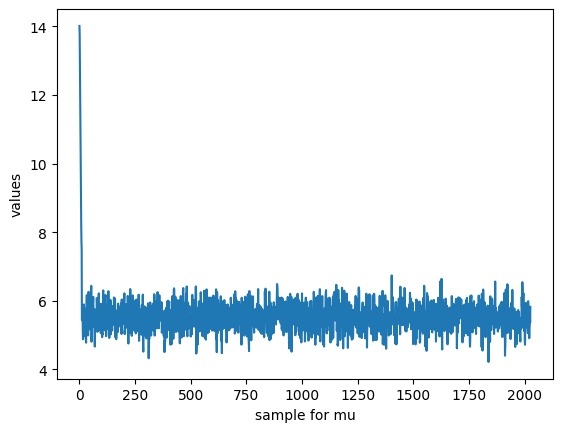

In [9]:
plt.plot(output_samples)
plt.xlabel('sample for mu')
plt.ylabel('values')
plt.show()

In [10]:
output_samples

[array([14.01362767]),
 array([13.79216561]),
 array([12.93564459]),
 array([11.66641755]),
 array([11.04015199]),
 array([10.67303607]),
 array([9.3296883]),
 array([9.02965134]),
 array([8.2111115]),
 array([7.72398001]),
 array([7.49628854]),
 array([5.44654507]),
 array([5.4285319]),
 array([5.73863892]),
 array([5.62036185]),
 array([5.11461465]),
 array([4.87755405]),
 array([5.08366591]),
 array([5.46585927]),
 array([5.43481241]),
 array([5.89253034]),
 array([5.39983277]),
 array([5.12101189]),
 array([5.51467629]),
 array([5.54011633]),
 array([5.648958]),
 array([5.76731431]),
 array([4.95364144]),
 array([5.02801561]),
 array([4.83460929]),
 array([4.77604628]),
 array([5.73641238]),
 array([5.83341799]),
 array([6.16176674]),
 array([5.6547962]),
 array([5.61179967]),
 array([5.55575513]),
 array([5.21745862]),
 array([5.34517063]),
 array([4.98742155]),
 array([5.30356198]),
 array([6.25969571]),
 array([6.11812336]),
 array([5.42838806]),
 array([5.61299892]),
 array([5.

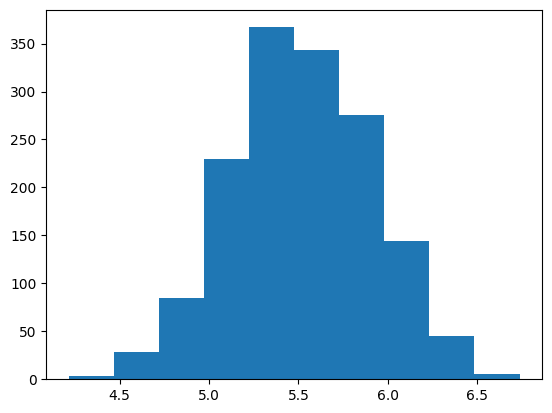

In [11]:
plt.hist(np.array(output_samples[500:]))
plt.show()

An important issues with the posterior samples in MCMC concerns the correlation between samples. Uncorrelated samples indicate that the sampling procedure is exploring properly the parameter space, and thus that our posterior distribution will be better represented. A high auto-correlation means that the Markov chain is taking small steps, and is not able to jump long distances. 

In our case it seems that the autocorrelation is under control and does not take pathological values.

**Exercise.** Can you modify the code above to obtain highly autocorrelated samples?

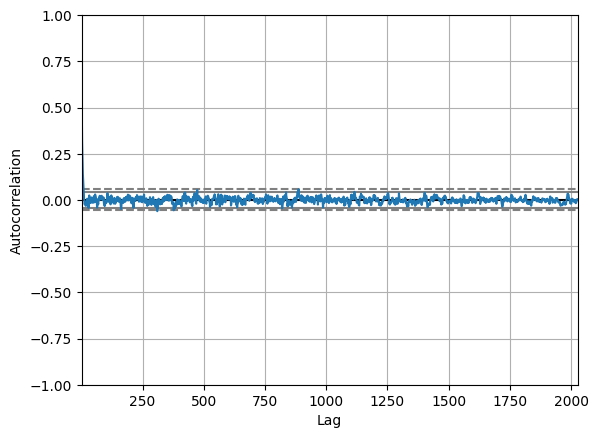

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(np.array(output_samples).flatten())
plt.show()


To reduce the pathological effects due non-representative samples, it is common practice to consider the Markov chain only after a certain number of steps (say 1000); this is called *burnin*. To mitigate the effect of autocorrelation we may consider one sample out of a certain number (say 5); this is called *thinning*. 

In [13]:
burnin = 50

effective_samples = output_samples[burnin:]

thinning = int(5)

list_samp = np.arange(0,len(effective_samples),thinning)

effective_samples = [effective_samples[i] for i in list_samp]


Be careful since burnin and thinning can considerably reduce the size of your samples, and thus lead to subsequent gross approximations of your posterior.

In [14]:
print(len(effective_samples))

396


In [15]:
print('MCMC sampling:')
print('mean: {} -- var: {}'.format(np.mean(effective_samples), np.var(effective_samples)))

MCMC sampling:
mean: 5.500588170540494 -- var: 0.16677621682195032


In [16]:
print('analytical posterior:')
print('mean: {} -- var: {}'.format(post_mean, post_var))

analytical posterior:
mean: 5.53324161021771 -- var: 0.13215141667486194


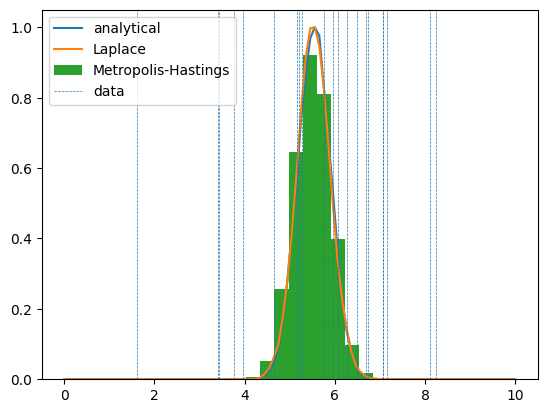

In [17]:
mcmc_post = np.random.normal(np.mean(effective_samples), np.std(effective_samples), 10000 )
mcmc_density = gaussian_kde(mcmc_post)


# Plotting posteriors
xs = np.linspace(0,10,100)
plt.plot(xs,analytical_density(xs)/np.max(analytical_density(xs)), label = 'analytical')
plt.plot(xs,laplace_density(xs)/np.max(laplace_density(xs)), label = 'Laplace')
#plt.plot(xs,mcmc_density(xs)/np.max(mcmc_density(xs)), label = 'Metropolis-Hastings')
plt.hist(mcmc_post, density = True, label = 'Metropolis-Hastings')
[plt.axvline(sample, ls = '--', lw = 0.5) for sample in y]

## Simple workaround for the legend
plt.axvline(y[0], ls = '--', lw = 0.5, label= 'data')
plt.legend()

plt.show()

**Exercise.** How would you design Metropilis-Hastings for estimating the joint distribution of mean and variance?

**Exercise.** How would you design Metropolis-Hastings for a linear model?

In [23]:
x = norm.rvs(0,1,100)
y = 5 + 8 * x + norm.rvs(0,5,100)

init_param = [0,1,0.1]
mu0 = 0
sigma0 = 4

In [24]:
def log_likelihood(param):
    log_pdf = 0
    for index,target in enumerate(y):
        mu = param[0] + param[1] * x[index]
        log_pdf += norm.logpdf(target,mu, param[2])                           
    return log_pdf

def log_prior(param):
    log_prior = 0
    for i in range(2):
        log_prior += norm.logpdf(param[i], mu0, sigma0)
    log_prior += uniform.logpdf(param[-1])
    return log_prior

def log_posterior(param):
    return log_likelihood(param) + log_prior(param)

def proposal(param, sigma):
    new_theta = [0,0,0]
    for i in range(len(param)):
        new_theta[i] = norm.rvs(param[i], sigma, size = 1)
    return(new_theta)

We notice that already in this simple case, our MCMC leads to quite slow computations, and to a very low number of usable posterior samples. 

In [26]:
print('The number of retained samples in the Markov chain is: ' + str(len(output_samples)))

The number of retained samples in the Markov chain is: 99


This fact is related to the course of dimensionality: as soon as the dimension of our sample space increases (in this case the dimension is 3) the number of possible parameters configurations scales accordingly. Therefore, it will be more and more difficult to exaustively explore the parameter space and faithfully represent the  posterior distribution. A small number of sample may still be sufficient for estimating the mean, but can easily lead to unreliable estimation of higher order quantities, such as the variance. 

In [27]:
samples_intercept = [output_samples[i][0] for i in range(len(output_samples))]
samples_slope = [output_samples[i][1] for i in range(len(output_samples))]
samples_sigma = [output_samples[i][2] for i in range(len(output_samples))]

burnin = 50

print('mean intercept: ' + str(np.mean(samples_intercept[burnin:])))
print('mean slope: ' + str(np.mean(samples_slope[burnin:])))
print('mean sigma: ' + str(np.mean(samples_sigma[burnin:])))
print('----------')
print('std intercept: ' + str(np.std(samples_intercept[burnin:])))
print('std slope: ' + str(np.std(samples_slope[burnin:])))
print('std sigma: ' + str(np.std(samples_sigma[burnin:])))

mean intercept: 3.0253063059081007
mean slope: 5.4027393691104
mean sigma: 0.9943415322569961
----------
std intercept: 1.0578373765864235
std slope: 1.0350649681697908
std sigma: 0.005466464331692632


The estimation of the average parameters is in agreement with the Laplace approximation below, however our MCMC estimate of the standard deviation may be quite inaccurate.

In [28]:
data = pd.DataFrame({'x': x, 'y': y})

expr = 'y ~ x'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 4
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 4
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 1
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])

/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 1827.2386231984235
 hess_inv: array([[ 2.37762812e-03,  5.54432884e-04, -1.39169971e-04],
       [ 5.54432884e-04,  6.24579056e-03, -6.92925256e-06],
       [-1.39169971e-04, -6.92925256e-06,  6.77847897e-05]])
      jac: array([ -113.61698914,     8.82881165, -3438.98013306])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 133
      nit: 8
     njev: 25
   status: 2
  success: False
        x: array([3.88861886, 8.26439236, 0.97728126])
           mean        SD      7.5%     92.5%
a      3.888965  0.047962  3.820511  3.959256
b      8.265332  0.078362  8.152997  8.377067
sigma  0.977450  0.008234  0.965507  0.989296


## Hamiltonian Monte Carlo and Stan

To overcome the problem of Metropolis-Hastings (and similar methods), in last years researchers focused on a novel approach to MCMC: Hamiltonian Monte Carlo (HMC). The basic idea of HMC consists in better exploring the target distribution by taking advantage of the geometric properties of the distribution itself. Conceptually, we define speed and direction at which we move across the parameters space from the differntial properties of the target distribution. This defines a set of dynamical systems that describe the trajectory to follow (Hamiltonian dynamics).

Going deep into the details of HMC is beyond the scope of this course, while for a better introduction to the topic we will take a look to the paper *A Conceptual Introduction to Hamiltonian Monte Carlo* of Michael Betancourt. A nice illustration of HMC at work can also be found in http://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html.

For the purpose of this course, we will use HMC through the implementation provided in Stan (https://mc-stan.org),  by using the Python interface of PyStan (https://pystan.readthedocs.io/en/latest/). The syntax of Stan (and PyStan) may seem a bit odd, especially for a Python user, and we will focus here on the basics.

In [29]:
import stan
#import nest_asyncio as asyncio
import nest_asyncio
nest_asyncio.apply()

In [30]:
# Generating ground Gaussian data for testing Stan
Nobs = 200
gt_mean = 5
gt_sigma = 2

obs = norm.rvs(gt_mean, gt_sigma, size = Nobs)

In [31]:
# Using Stan for inference
## A simple model to explore the Gaussian likelihood 
model_code = """
data {
    int<lower=1> N;
    real y[N];
}
parameters {
    real mu;
    real<lower=1e-4> ystd;
}
model {
    y ~ normal(mu, ystd);
}
"""

In [32]:
print(model_code)


data {
    int<lower=1> N;
    real y[N];
}
parameters {
    real mu;
    real<lower=1e-4> ystd;
}
model {
    y ~ normal(mu, ystd);
}



In [33]:
seed = 123

posterior = stan.build(model_code, data=dict(y=obs, N=Nobs), random_seed=seed)


Building: found in cache, done.
Messages from stanc:


In [34]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!


In [35]:
df = fit.to_frame()
print(df.describe().T)

                count        mean       std         min         25%  \
parameters                                                            
lp__           4000.0 -239.519364  0.964856 -246.416890 -239.924198   
accept_stat__  4000.0    0.909242  0.117087    0.031133    0.871107   
stepsize__     4000.0    0.863184  0.100958    0.755222    0.796691   
treedepth__    4000.0    1.901000  0.539233    1.000000    2.000000   
n_leapfrog__   4000.0    3.633000  1.798922    1.000000    3.000000   
divergent__    4000.0    0.000000  0.000000    0.000000    0.000000   
energy__       4000.0  240.531996  1.408090  238.530532  239.495988   
mu             4000.0    4.970428  0.141416    4.455765    4.872599   
ystd           4000.0    2.022625  0.101923    1.678367    1.950095   

                      50%         75%         max  
parameters                                         
lp__          -239.218155 -238.820589 -238.525968  
accept_stat__    0.953067    0.995349    1.000000  
stepsize__

The report looks very similar to the ones we are already used to get with our previous inference methods (in addition it provides also statistics for the log-posterior, here called *lp__*). There are some additional fields here, for example *divergent__* which is a diagnostic for our HMC chain. Divergence indicates the presence of pathological neighborhoods of the posterior that the simulated Hamiltonian trajectories are not able to explore sufficiently well.   

In [36]:
#Getting the estimated parameters
est_mu = fit['mu'][0]
est_std = fit['ystd'][0]

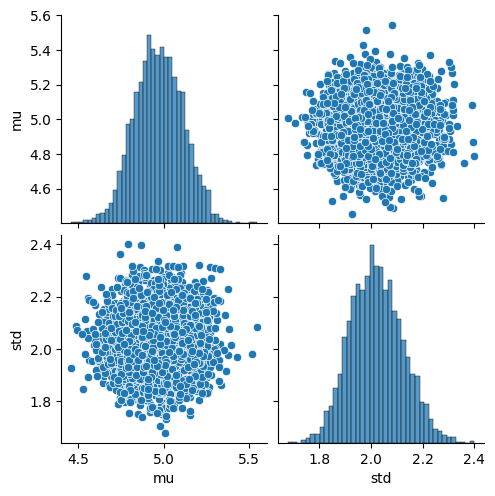

In [37]:
import seaborn as sns

g = sns.pairplot(pd.DataFrame({'mu':est_mu, 'std':est_std}))

Text(0.5, 1.0, 'est_mu')

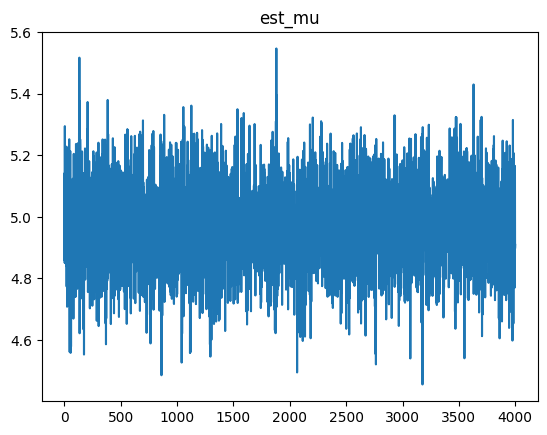

In [38]:
plt.plot(est_mu)
plt.title('est_mu')

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu    4.970  0.141   4.720    5.236      0.002    0.002    3573.0    2875.0   
ystd  2.023  0.102   1.833    2.211      0.002    0.001    3247.0    2753.0   

      r_hat  
mu      1.0  
ystd    1.0  


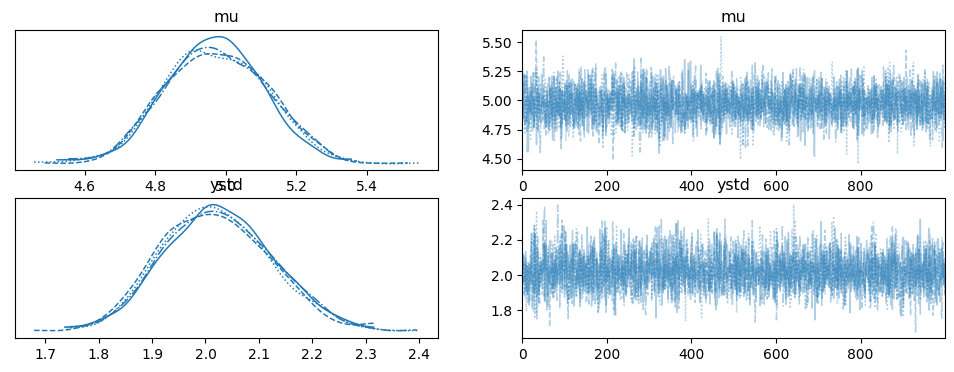

In [39]:
import arviz as az
az.plot_trace(fit)
summary = az.summary(fit)
print(summary)

*r_hat* is an estimate of the convergence of the Markov chain. If it's 1, that's a good sign, otherwise this may point to some serious problems with our model.

We now explore the more complicated case of linear regression

In [40]:
Nobs = 100

x = norm.rvs(0,1,Nobs)
y = 5 + 8 * x + norm.rvs(0,5,Nobs)

init_param = [0,1,0.1]
mu0 = 0
sigma0 = 4

In [41]:
linear_model_1d_code = """
data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;
}
parameters {
    real a;
    real b;
    real<lower=1e-4> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = a + b * x; 
}
model {

  target += uniform_lpdf(sigma | 0, 10);       // prior log-density
  target += normal_lpdf(a | 0, 4);       // prior log-density
  target += normal_lpdf(b | 0, 4);       // prior log-density
  target += normal_lpdf(y | mu, sigma); // log-likelihood

}
"""


In [42]:
data = dict(x = x, y = y, N = Nobs)
posterior = stan.build(linear_model_1d_code, data=data, random_seed=123)

Building: found in cache, done.


In [43]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000542 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        5.050  0.417   4.250    5.809      0.007    0.005    3891.0   
b        8.297  0.447   7.435    9.113      0.007    0.005    4106.0   
sigma    4.306  0.312   3.742    4.911      0.005    0.003    4281.0   
mu[0]   -2.161  0.554  -3.208   -1.142      0.008    0.006    4652.0   
mu[1]   -4.695  0.652  -5.826   -3.384      0.010    0.007    4660.0   
...        ...    ...     ...      ...        ...      ...       ...   
mu[95]   8.538  0.467   7.696    9.430      0.008    0.006    3607.0   
mu[96]   1.214  0.455   0.341    2.030      0.007    0.005    4392.0   
mu[97]   0.331  0.476  -0.576    1.204      0.007    0.006    4487.0   
mu[98]  -3.738  0.613  -4.849   -2.558      0.009    0.006    4666.0   
mu[99]  21.373  0.993  19.522   23.243      0.016    0.012    3720.0   

        ess_tail  r_hat  
a         2747.0    1.0  
b         3242.0    1.0  
sigma     2725.0    1.0  
mu[0]     3197.0    1.0  
mu[1]

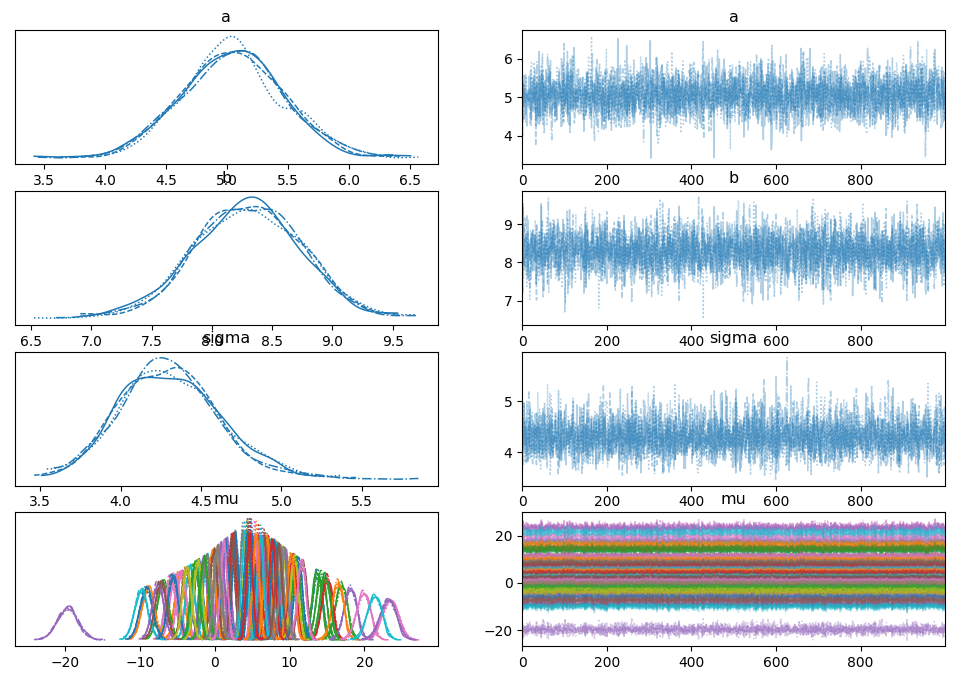

In [44]:
az.plot_trace(fit)
summary = az.summary(fit)
print(summary)

In [45]:
#Getting the estimated parameters
est_a = fit['a'][0]
est_b = fit['b'][0]
est_sigma = fit['sigma'][0]


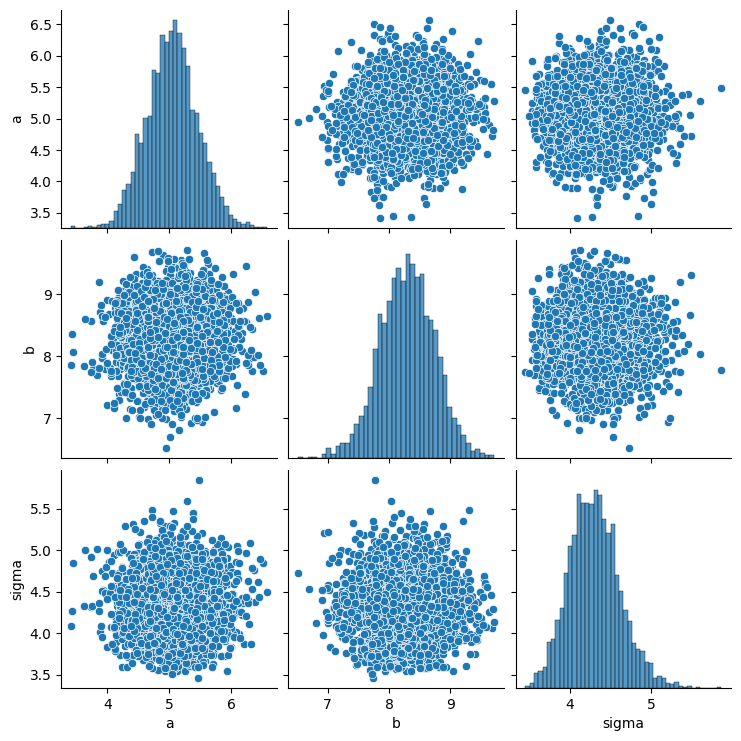

In [46]:
g = sns.pairplot(pd.DataFrame({'a':est_a, 'b':est_b, 'sigma': est_sigma}))

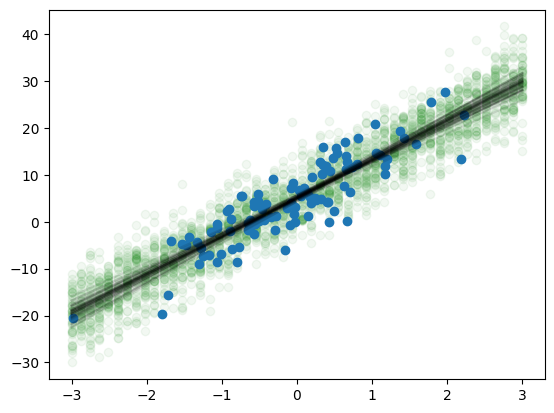

In [47]:
N_models = 50

x_range = np.linspace(-3,3)

for i in range(N_models):
    prediction = np.random.choice(est_a) + np.random.choice(est_b) * x_range
    plt.plot(x_range, prediction, alpha = 0.1, color = 'black')

    for i, pred in enumerate(prediction):
        samples = norm.rvs(pred, np.random.choice(est_sigma), size = 1)
        plt.scatter(x_range[i], samples, color = 'green', alpha = 0.05)
        
plt.scatter(x,y)
plt.show()



# When HMC goes wrong

In [48]:
y = np.array([-1,1])

In [49]:
wrong_model_code = """
data {
    int<lower=1> N;
    vector[N] y;
}
parameters {
    real mu;
    real<lower=1e-4> sigma;
}
model {
    y ~ normal(mu, sigma);
}
"""



In [50]:
data = dict(y = y, N = 2)
posterior = stan.build(wrong_model_code, data=data, random_seed=123)

Building: found in cache, done.
Messages from stanc:


In [51]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!


In [52]:
est_mu = fit['mu'][0]
est_sigma = fit['sigma'][0]

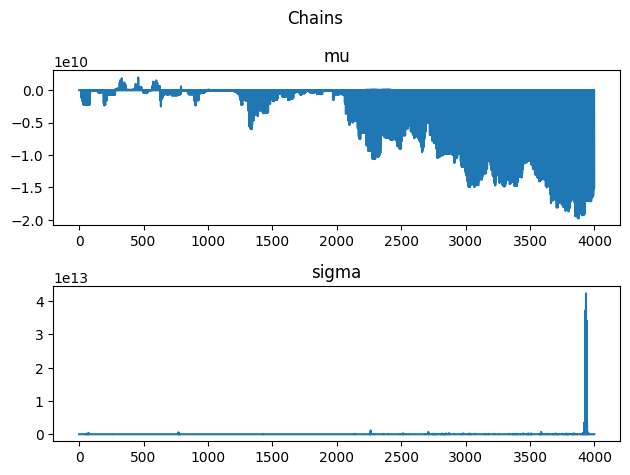

In [53]:
fig, axs = plt.subplots(2)
fig.suptitle('Chains')
axs[0].plot(est_mu)
axs[0].set_title('mu')
axs[1].plot(est_sigma)
axs[1].set_title('sigma')
fig.tight_layout()

In [54]:
df = fit.to_frame()
print(df.describe().T)

                count          mean           std           min           25%  \
parameters                                                                      
lp__           4000.0 -1.609147e+01  4.981781e+00 -3.137561e+01 -1.954902e+01   
accept_stat__  4000.0  9.184556e-01  1.943307e-01  0.000000e+00  9.596134e-01   
stepsize__     4000.0  1.138859e-01  7.473263e-02  1.379672e-02  6.837637e-02   
treedepth__    4000.0  4.895750e+00  2.773681e+00  0.000000e+00  3.000000e+00   
n_leapfrog__   4000.0  2.037295e+02  3.524093e+02  1.000000e+00  7.000000e+00   
divergent__    4000.0  1.500000e-02  1.215677e-01  0.000000e+00  0.000000e+00   
energy__       4000.0  1.708554e+01  5.095346e+00  6.667978e+00  1.312558e+01   
mu             4000.0 -1.478379e+09  3.993500e+09 -1.978562e+10 -4.923931e+07   
sigma          4000.0  3.742377e+10  1.046476e+12  6.459607e+02  1.198571e+05   

                        50%           75%           max  
parameters                                        

We can see that the number of effective samples is very low, and that *Rhat* is greater than one. Also, when exploring the chain itself we notice that the mixing is very poor, and the values can go to very extreme values. How is this possible?

The problem in this case consists in the flat prior for the parameters $\mu$ and $\sigma$. Therefore, since the likelihood is not strong enough, the Markov chain has the tendency to drift away in a very unpredictable way. A way to fix this problem consists in using priors, even if not much informative.

In [55]:
better_model_code = """
data {
    int<lower=1> N;
    vector[N] y;
}
parameters {
    real mu;
    real<lower=1e-4> sigma;
}
model {
    mu ~ normal(0, 5);
    sigma ~ cauchy(0, 1);
    y ~ normal(mu, sigma);
}
"""

data = dict(y = y, N = 2)
posterior = stan.build(better_model_code, data=data, random_seed=123)

Building: found in cache, done.


In [56]:
fit = posterior.sample(num_chains=4, num_samples=1000)
est_mu = fit['mu'][0]
est_sigma = fit['sigma'][0]

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!


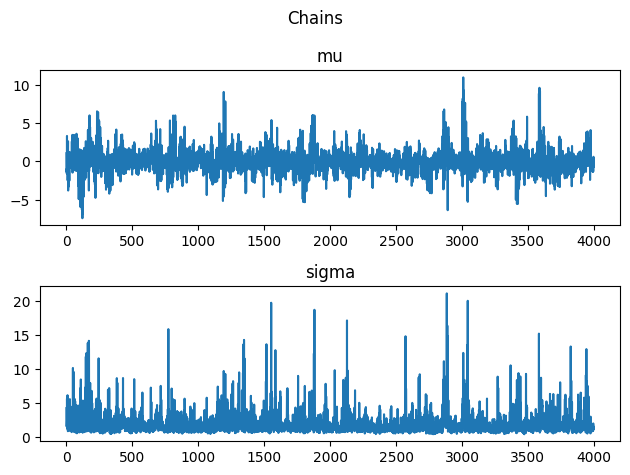

In [57]:
fig, axs = plt.subplots(2)
fig.suptitle('Chains')
axs[0].plot(est_mu)
axs[0].set_title('mu')
axs[1].plot(est_sigma)
axs[1].set_title('sigma')
fig.tight_layout()

In [58]:
df = fit.to_frame()
print(df.describe().T)

                count      mean       std           min       25%       50%  \
parameters                                                                    
lp__           4000.0 -3.051265  1.324066 -1.078675e+01 -3.615272 -2.628191   
accept_stat__  4000.0  0.876491  0.203281  5.338915e-64  0.865626  0.959742   
stepsize__     4000.0  0.535560  0.043195  4.840486e-01  0.498257  0.535136   
treedepth__    4000.0  2.162750  0.639425  1.000000e+00  2.000000  2.000000   
n_leapfrog__   4000.0  4.833000  2.286792  1.000000e+00  3.000000  5.000000   
divergent__    4000.0  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
energy__       4000.0  4.054332  1.676618  1.712597e+00  2.798743  3.673292   
mu             4000.0  0.032851  1.477677 -7.438065e+00 -0.667466 -0.011313   
sigma          4000.0  1.979368  1.740189  4.050242e-01  1.026987  1.465116   

                    75%        max  
parameters                          
lp__          -2.076120  -1.694054  
accept_stat__  0.99

Traceback (most recent call last):
  File "/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/site-packages/traitlets/config/application.py", line 985, in launch_instance
    app.start()
  File "/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/Users/mlorenzi/miniconda3/envs/pymc3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
